### HuggingFace | BERT | PyTorch
- [Code Source](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f' Computations will utilize: {device}')
print('#####  Inital Program Setup is Complete  #####')

 Computations will utilize: cpu
#####  Inital Program Setup is Complete  #####


In [2]:
# Import data
df = pd.read_csv(r'C:\Data Sciences\data\all_data\reviews.csv')
print(f' Dataframe Shape: {df.shape}')
df.info()
df.head()

 Dataframe Shape: (15746, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


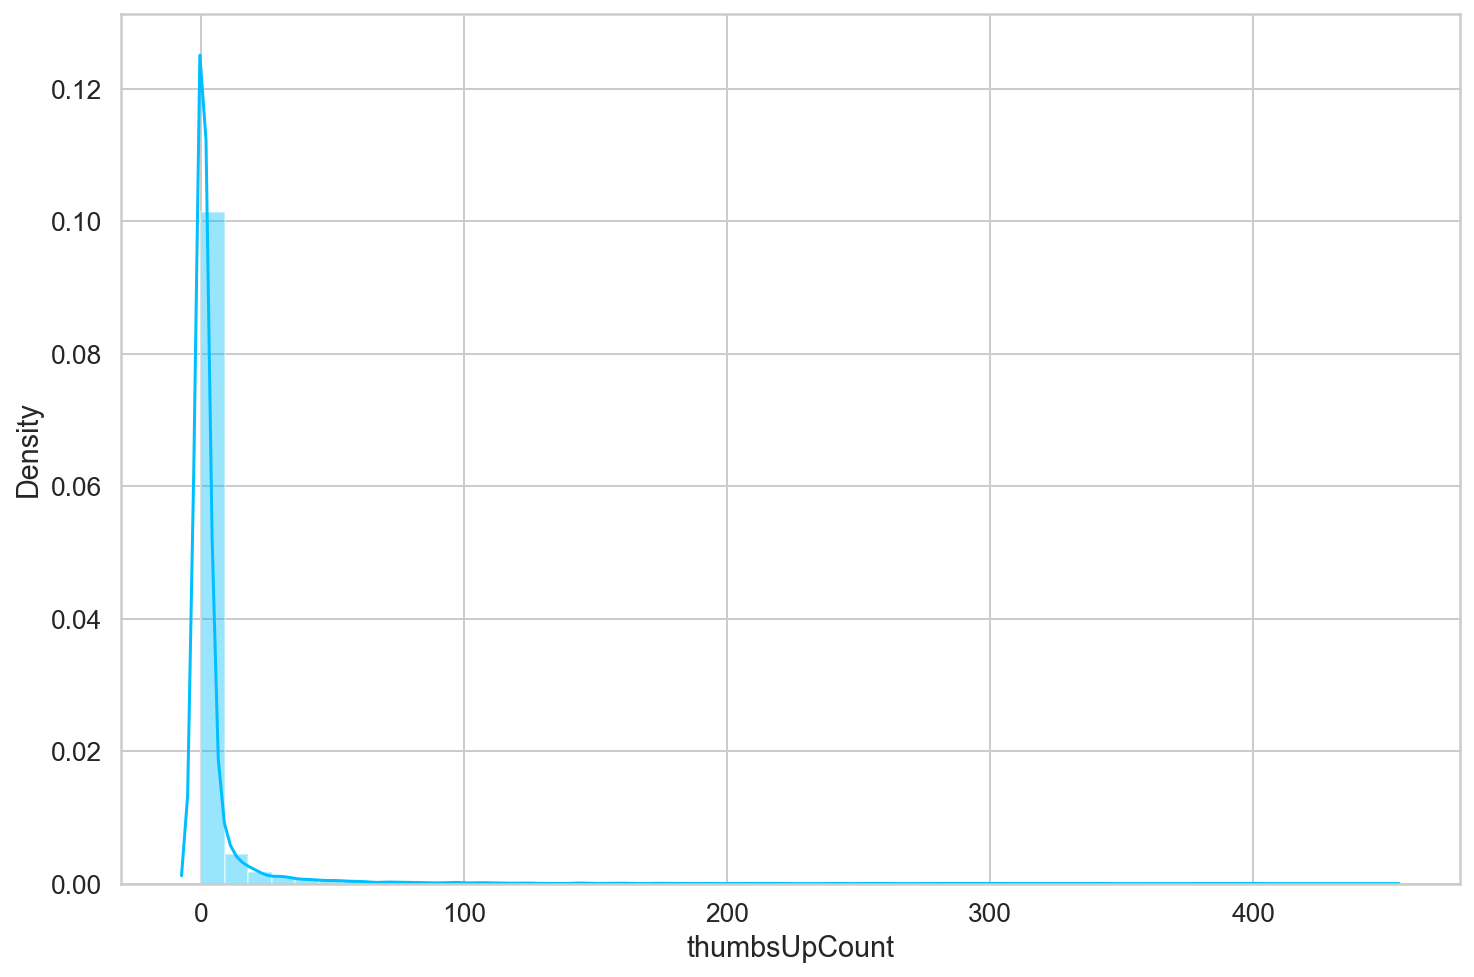

In [3]:
sns.distplot(df['thumbsUpCount'])
plt.savefig('Thumbs Distribution by Counts.png')

In [4]:
def thumbs_up(thumbs):
    thumbs = int(thumbs)

    if thumbs <= 1:
        return '0-1'

    elif thumbs >=2 and thumbs <=3:
        return '2-3'

    elif thumbs >=4 and thumbs <=5:
        return '4-5'

    elif thumbs >=6 and thumbs <=7:
        return '6-7'

    else:
        return 'Over-8'

df['thumbs_up_grouping'] = df.thumbsUpCount.apply(thumbs_up)

<AxesSubplot:xlabel='thumbs_up_grouping', ylabel='count'>

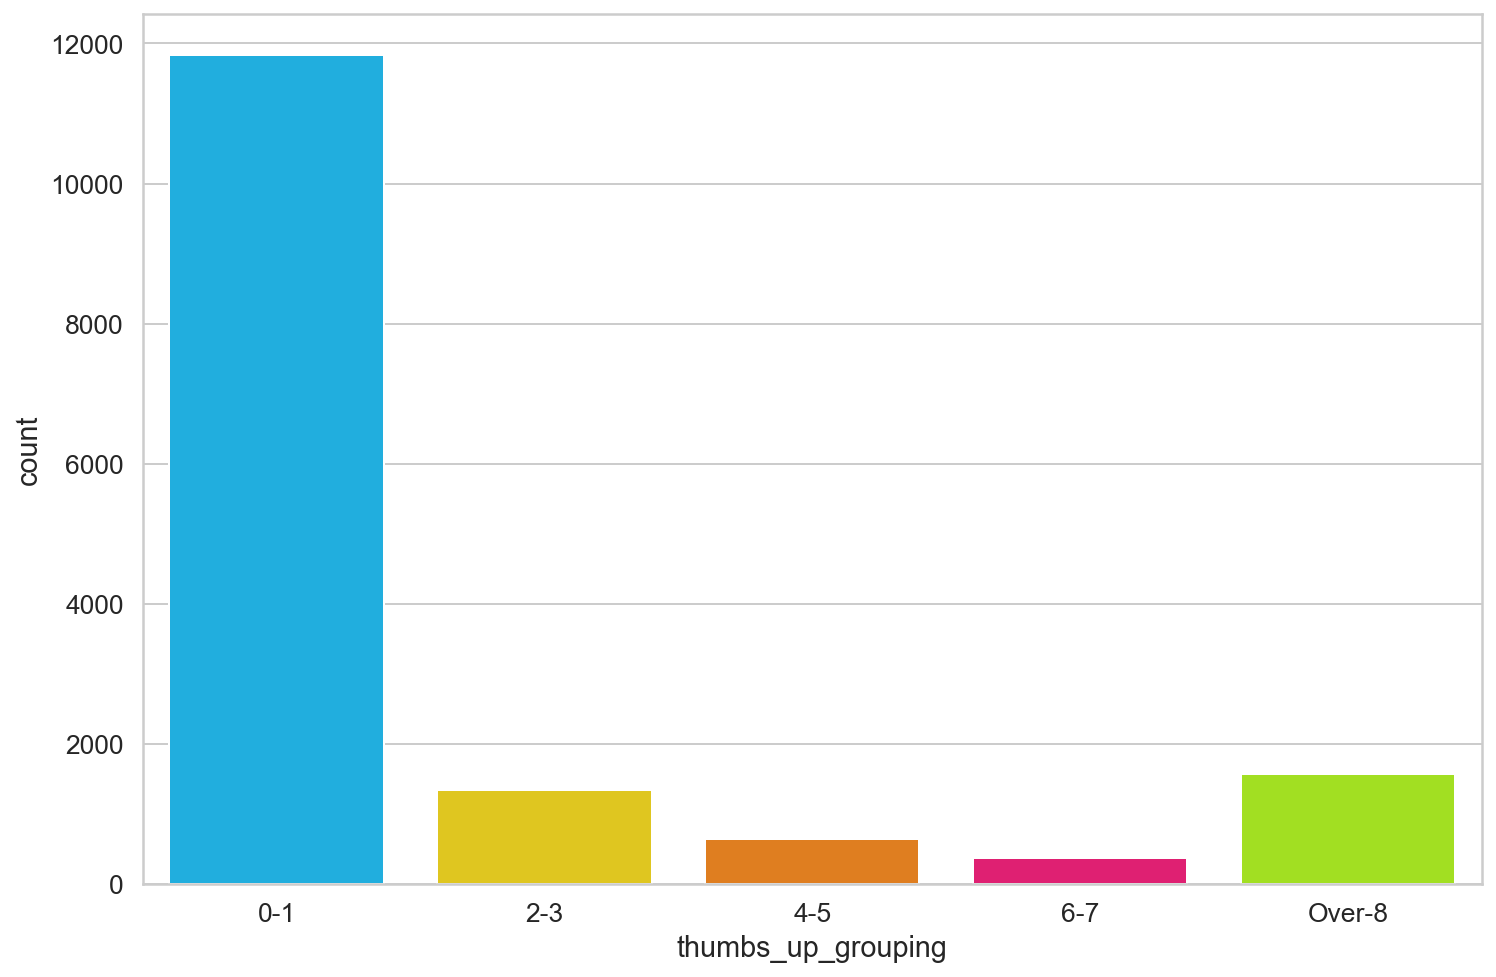

In [5]:
order = ['0-1','2-3','4-5','6-7','Over-8']
sns.countplot(df['thumbs_up_grouping'], order=order)

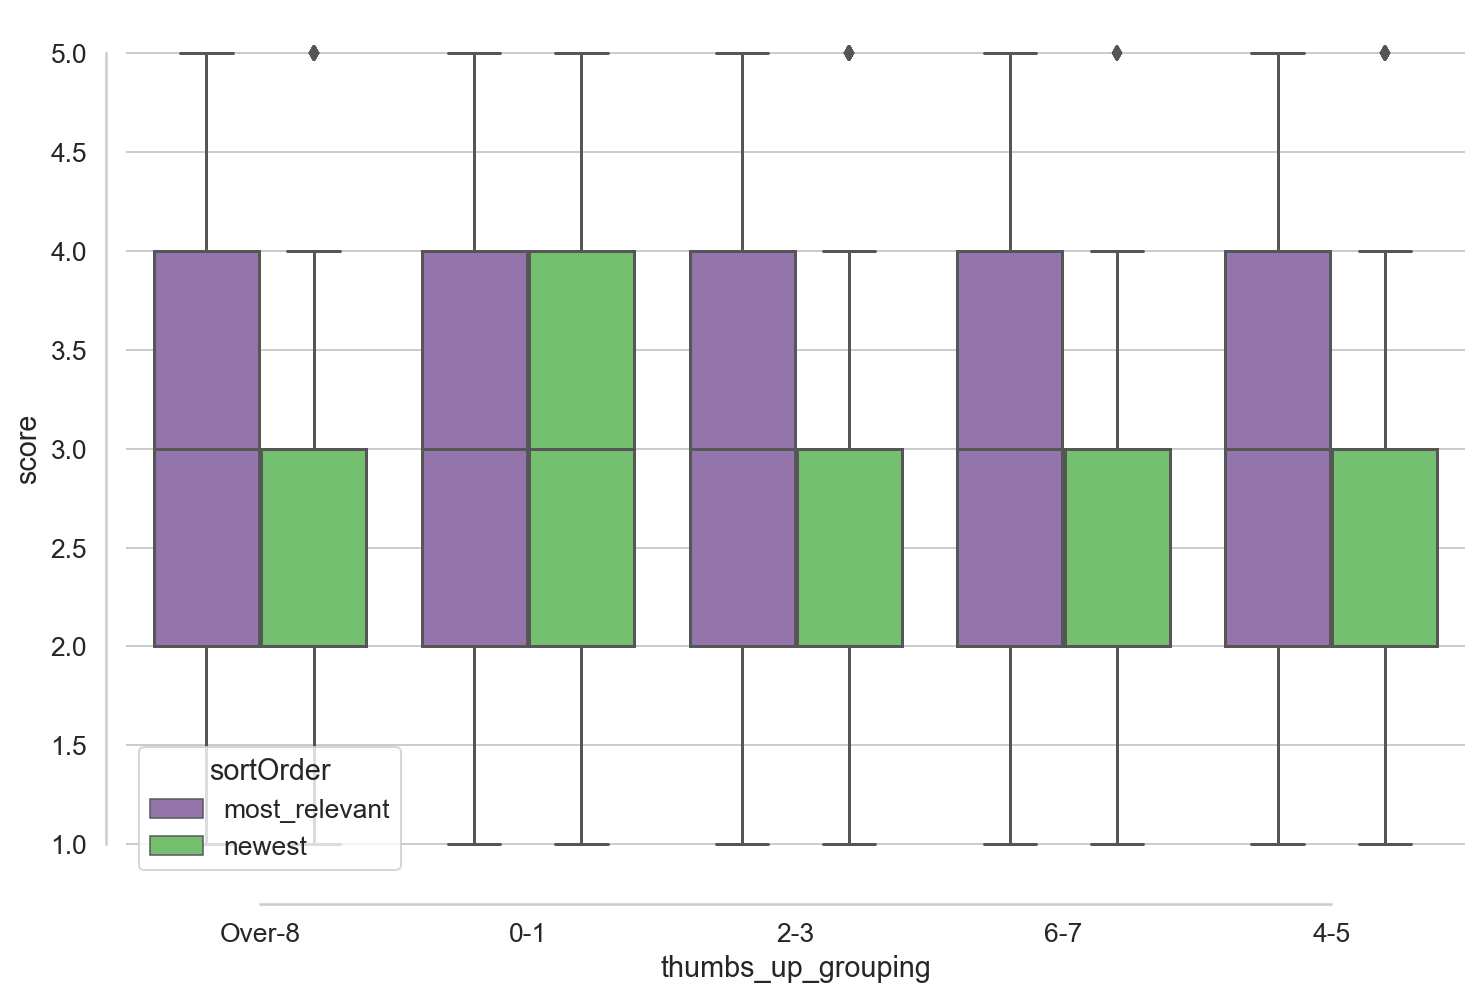

In [6]:
sns.boxplot(x="thumbs_up_grouping", y="score", hue = "sortOrder", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

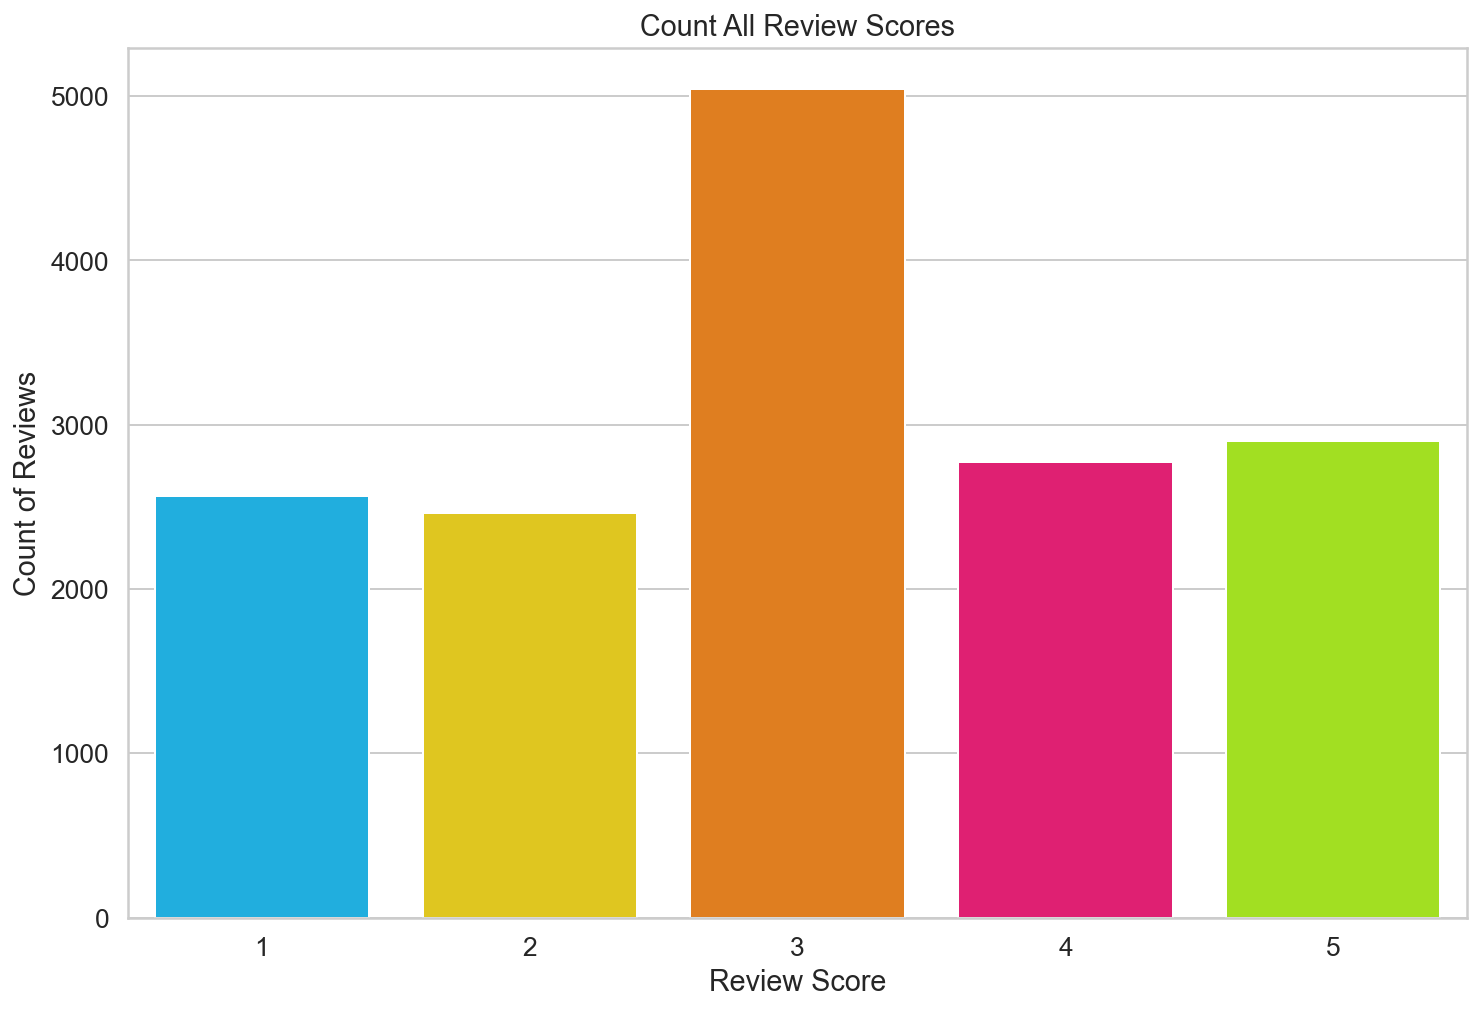

In [7]:
# Review distribution of review score:
sns.countplot(df.score)
plt.title('Count All Review Scores')
plt.ylabel('Count of Reviews')
plt.xlabel('Review Score')
plt.savefig('Pre-Processed Review Scores.png')

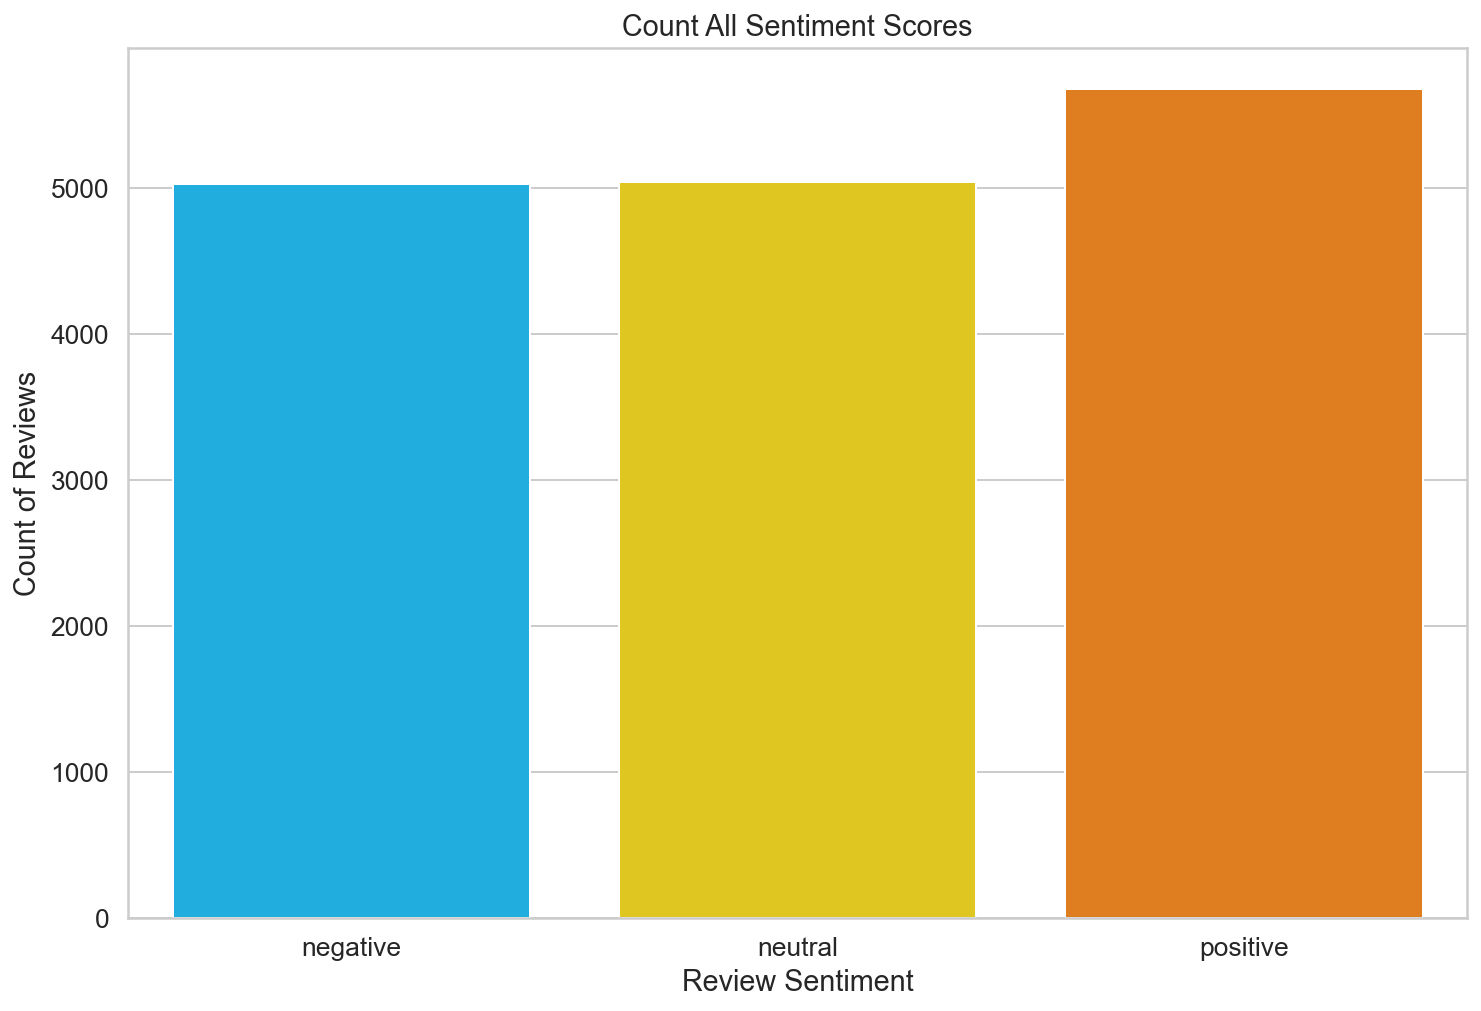

In [8]:
# Re-assign review scores into 0 (negative), 1 (neutral), and 2 (positive):
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.title('Count All Sentiment Scores')
plt.ylabel('Count of Reviews')
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names)
plt.savefig('Post-Processed Sentiment Scores.png')

In [9]:
# Constaint Variables:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [11]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [12]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [13]:
df.head(3)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,thumbs_up_grouping,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,Over-8,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,Over-8,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,Over-8,0


Text(0.5, 0, 'Token count')

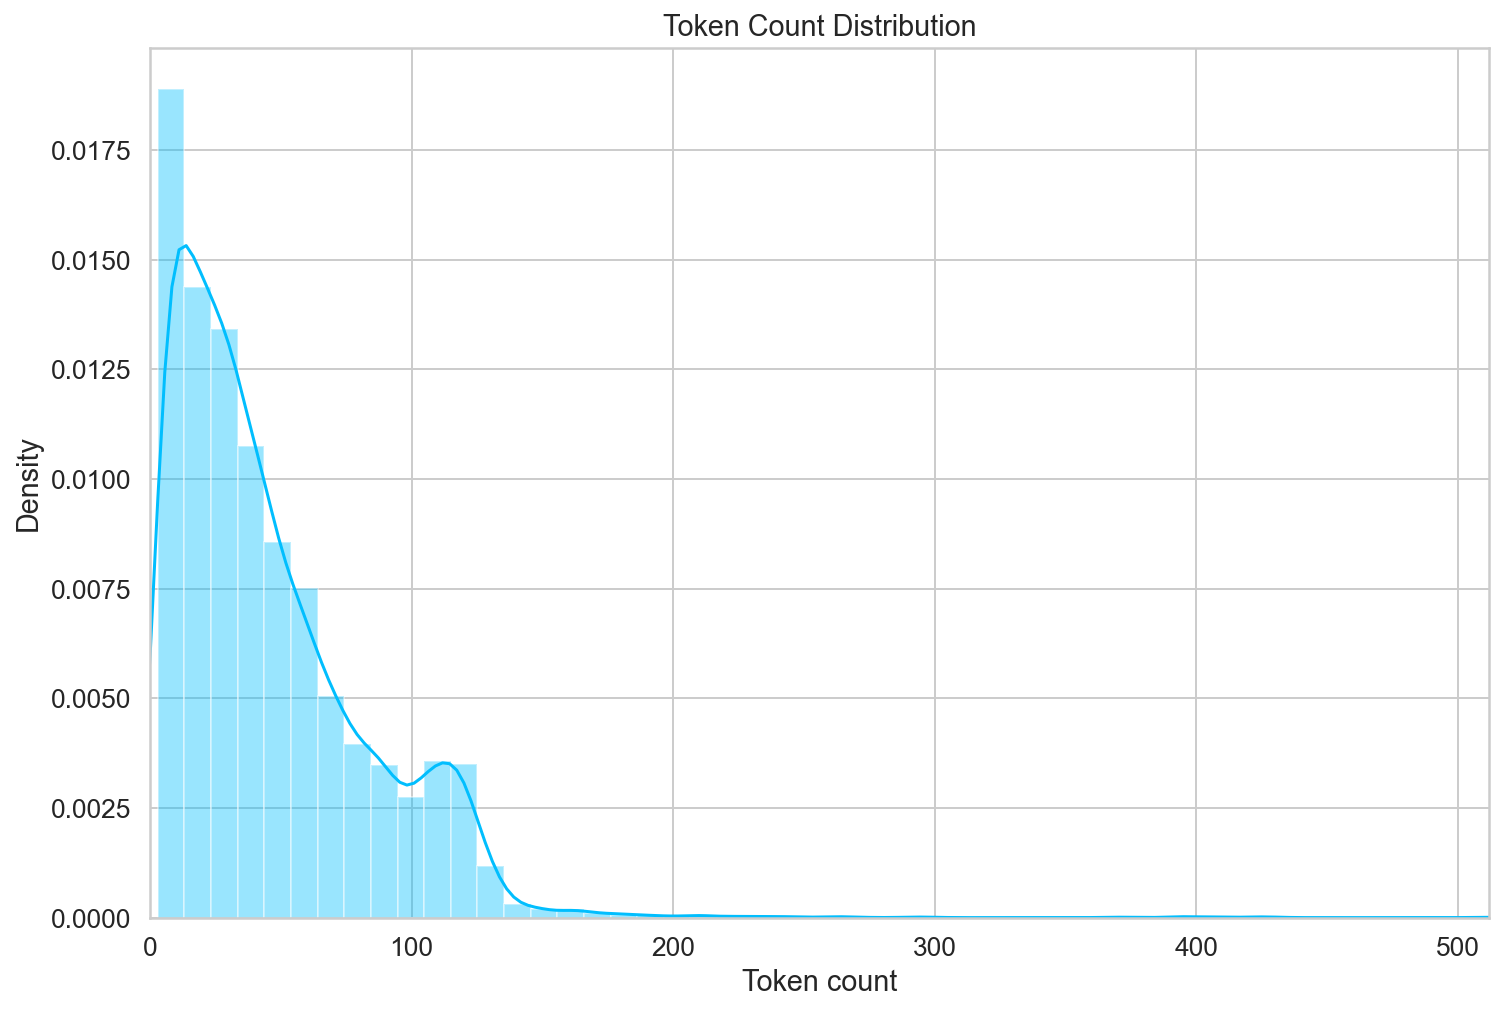

In [14]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.title('Token Count Distribution')
plt.xlim([0, 512]);
plt.xlabel('Token count')

In [15]:
class GPReviewDataset(Dataset):

  ''' This class will create a pytorch dataset'''

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [16]:
# Based on distribution from above, it appears 160 MAX_LEN will work for this problem:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [17]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state=RANDOM_SEED)

print('### Shape Describtion ###')
print(f'      Train Shape: {df_train.shape}')
print(f'       Test Shape: {df_test.shape}')
print(f' Validation Shape: {df_val.shape}')

### Shape Describtion ###
      Train Shape: (14171, 13)
       Test Shape: (788, 13)
 Validation Shape: (787, 13)


In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [19]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

NameError: name 'data' is not defined

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'], 
    attention_mask = encoding['attention_mask']
)